In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from encoder_lib import MLPEncoder, StarNetEncoder
from dataset_lib import CenteredStarsData, trim_psf
import optimization_lib

from which_device import device


print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [3]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 11
psf = trim_psf(psf, slen)

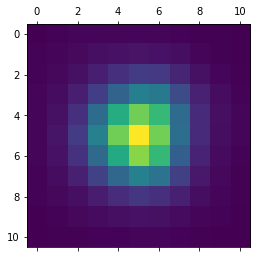

In [4]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [5]:
n_images = 10000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

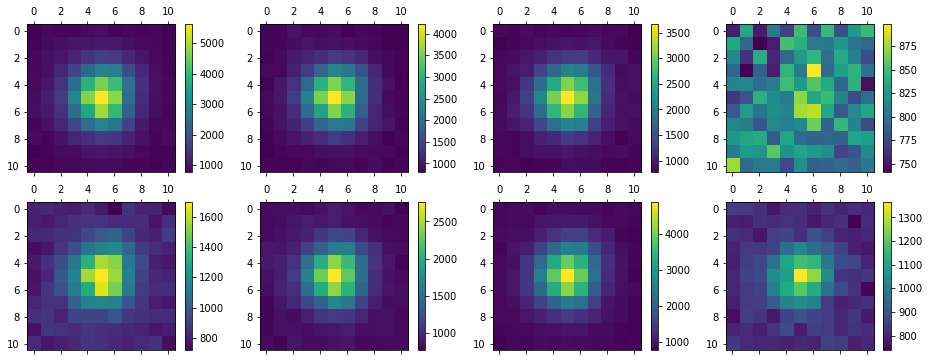

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(16, 6))

for i in range(8): 
        
    x0 = i // 4
    x1 = i % 4
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [7]:
network = MLPEncoder(slen = slen).to(device)
network

# network = StarNetEncoder(slen = slen).to(device)

MLPEncoder(
  (fc1): Linear(in_features=121, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

# Define dataset

In [8]:
batch_size = 128
train_data = DataLoader(star_data, 
                         batch_size=batch_size)


test_data = DataLoader(star_data, 
                       batch_size=n_images)

# Choose the loss function

In [9]:
loss_fun = optimization_lib.klpq

In [10]:
import inspect
lines = inspect.getsource(loss_fun)
print(lines)

def klpq(network, batch): 
    
    x = batch['image']
    y = batch['flux'].squeeze()
        
    est, sd = network(x)
        
    norm = normal.Normal(loc = est, scale = sd)
    
    loss = - norm.log_prob(y)
    
    return loss, y, est, sd



# Train 

In [11]:
# initial loss 
for _, test_batch in enumerate(test_data):
    break
    
loss = loss_fun(network, test_batch)[0].mean()
print('initial loss: {}'.format(loss))

initial loss: 4279.64697265625


In [12]:
# define optimizer 
n_epochs = 20

optimizer = optim.Adam(network.parameters(), 
                       lr = 1e-3)

In [13]:
# now optimize
optimization_lib.train_network(network, loss_fun, train_data, optimizer, n_epochs)

epoch [0]. loss = 125.13079833984375
epoch [1]. loss = 27.352602005004883
epoch [2]. loss = 19.018367767333984
epoch [3]. loss = 16.124326705932617
epoch [4]. loss = 14.280065536499023
epoch [5]. loss = 13.468619346618652
epoch [6]. loss = 12.733302116394043
epoch [7]. loss = 12.398834228515625
epoch [8]. loss = 12.182395935058594
epoch [9]. loss = 11.875724792480469
epoch [10]. loss = 11.749388694763184
epoch [11]. loss = 11.62256908416748
epoch [12]. loss = 11.509078979492188
epoch [13]. loss = 11.436945915222168
epoch [14]. loss = 11.388911247253418
epoch [15]. loss = 11.30913257598877
epoch [16]. loss = 11.299600601196289
epoch [17]. loss = 11.275047302246094
epoch [18]. loss = 11.265172958374023
epoch [19]. loss = 11.198564529418945
done. Elapsed 38.538sec


# check results

In [14]:
# final loss
network.eval()
loss, truth, est, sd = loss_fun(network, test_batch)
print('final loss: {}'.format(loss.mean()))

final loss: 11.198002815246582


Text(0, 0.5, 'true')

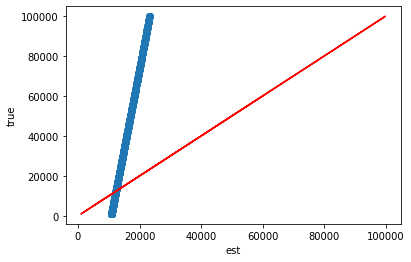

In [15]:
plt.scatter(est.detach().cpu(), 
            truth.cpu())

# x = y line
plt.plot(truth.cpu(), truth.cpu(), color = 'red')

plt.xlabel('est')
plt.ylabel('true')

### Plot some residuals

In [21]:
exp_flux = False

In [22]:
def reconstruct_image(flux): 
    return star_data.psf * flux + star_data.background

In [28]:
star_data.psf.shape

torch.Size([11, 11])

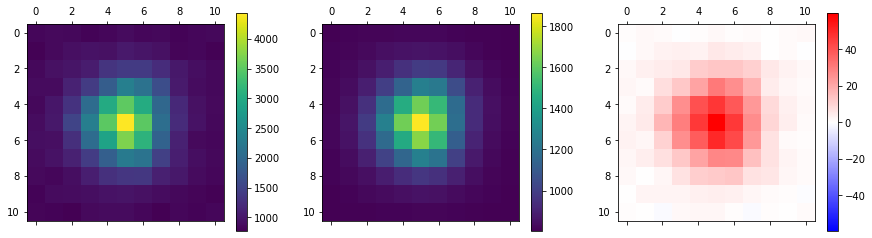

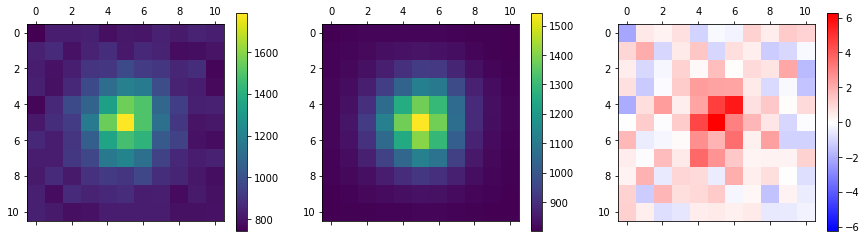

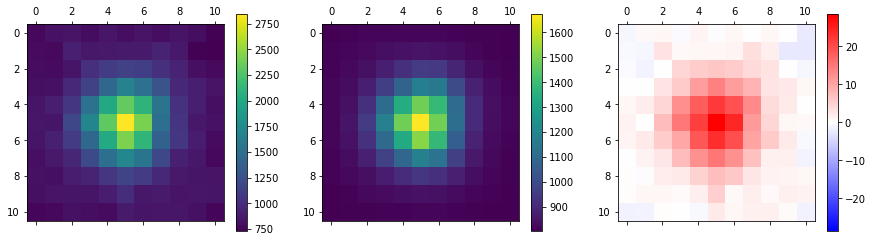

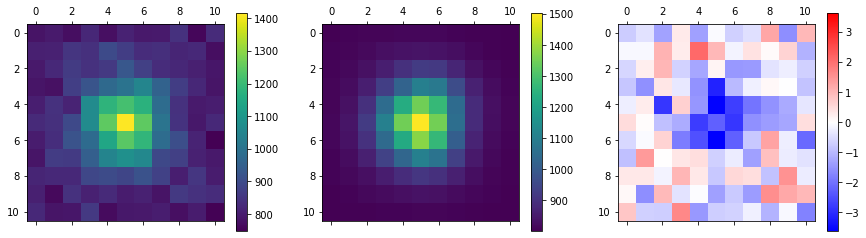

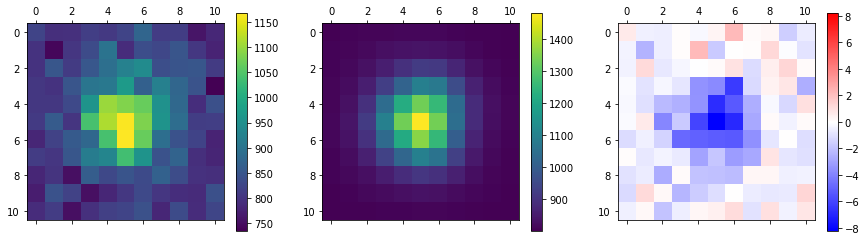

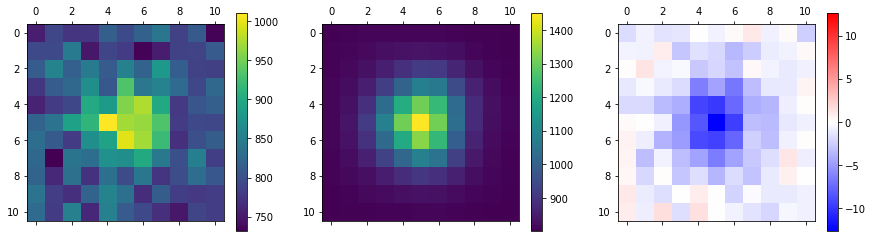

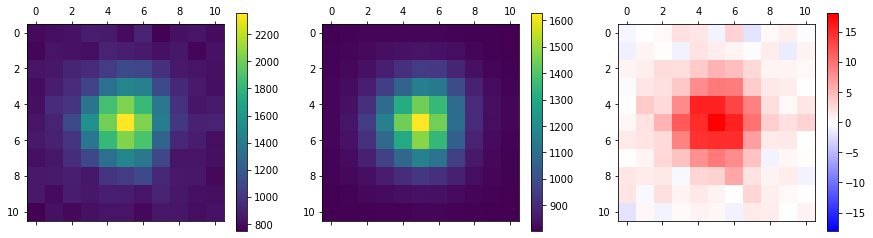

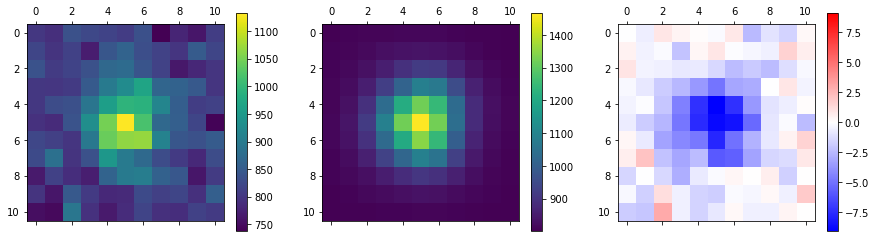

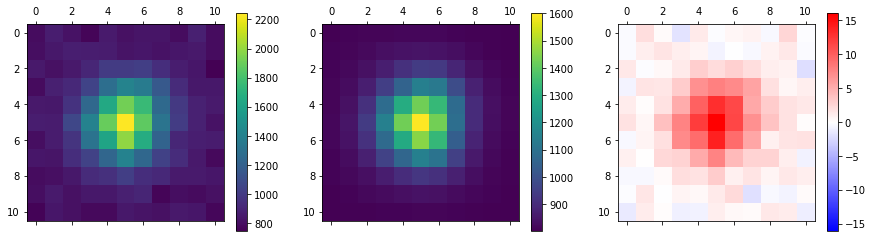

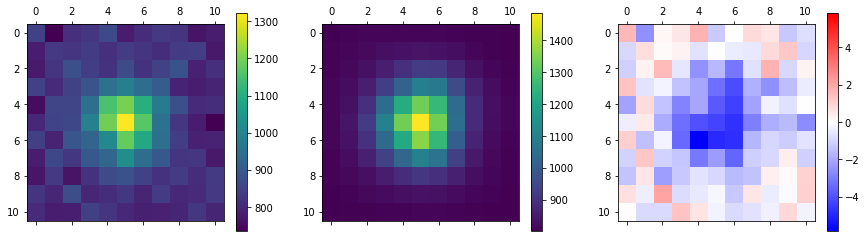

In [23]:
for i in range(10): 
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    image = test_batch['image'][i, 0].cpu()
    
    true_flux = truth[i]
    est_flux = est[i].detach().cpu()
    
    if exp_flux: 
        est_flux = est_flux.exp()
        true_flux = truth.exp()
    
    # plot true image    
    im = ax[0].matshow(image)
    fig.colorbar(im, ax = ax[0])

    # plot reconstructed image 
    recon = reconstruct_image(est_flux).cpu()
    im1 = ax[1].matshow(recon)
    fig.colorbar(im1, ax = ax[1])
    
    # plt residual 
    resid = (image - recon) / torch.sqrt(recon)
    vmax = resid.abs().max()
    im2 = ax[2].matshow(resid, 
                        vmax = vmax, 
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    fig.colorbar(im2, ax = ax[2])

# Check SDs

(array([5058., 1484.,  852.,  640.,  522.,  359.,  331.,  277.,  256.,
         221.]),
 array([10802.408 , 12053.1875, 13303.966 , 14554.745 , 15805.523 ,
        17056.303 , 18307.082 , 19557.861 , 20808.639 , 22059.418 ,
        23310.197 ], dtype=float32),
 <BarContainer object of 10 artists>)

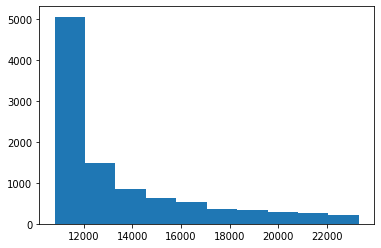

In [24]:
plt.hist(sd.detach().cpu().numpy())

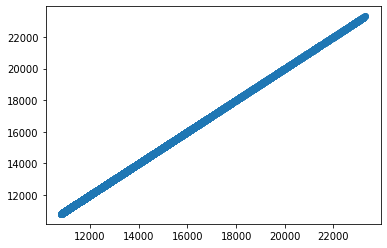

In [27]:
plt.scatter(est.detach().cpu().numpy(), 
            sd.detach().cpu().numpy())